# Monitoring of model
 Evaluate model on data and obtain metrics of performance

## Load libraries

In [1]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install lightgbm

In [3]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data to evaluate

Load variables names from file

In [8]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [9]:
import os
import joblib
# load model
#modelo = joblib.load("ModeloV2TodosMenosVariables.pkl") 
#variables = open('./ModeloV2TodosMenosVariables.txt','r')
modelo = joblib.load("ModeloFinal2.pkl") 
variables = open('./ModeloFinal2.txt','r')

In [10]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

## Veo si puedo sacar los nombres directo del modelo q cargue
## Veo como cargar el punto de corte

In [11]:
variables = open('./ModeloFinal2.txt','r')
var_input = variables.read()

In [12]:
var_input = ['01_branch_working_days', 'branch_minutes_since_last_transaction',
    'branch_trans_3m', 'branch_has_fraud', 
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','01_isMexico', 
    '01_sender_branch_state', '01_var_range_hist',
    '01_branch_fraud', '01_location_fraud', '01_sender_fraud', 
    '01_isCashPick', '01_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    '01_receiver_transaction_count', '01_sender_sending_days',
    '01_branch_working_days', '01_net_amount_receiver', 
    '01_sender_minutes_since_last_transaction_2days', 
    '01_sender_days_to_last_transaction_365', 
    '01_sender_days_to_last_transaction_7m', '01_hour_receiver']

In [13]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
#X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

In [14]:
# Uso esto para sacar el punto de corte. Cuando lo pueda guardar esta celda se va
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Creando una copia del DataFrame 'Y_c' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

#Calculo el primer percentil para sacar el punto de corte
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

#saco el punto de corte del primer centil para aplicarlo al test
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [15]:
corte

1.976573014763343e-08

In [16]:
corte_01

1.1511944114690123e-06

In [18]:
Y_c['pred_corte'] = Y_c['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,16708132,16373
1,12,351


In [19]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

## Apply model

In [20]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [21]:
testeo['target'].value_counts(dropna=False)

target
False    23212824
True          419
Name: count, dtype: int64

In [22]:
Y_target.shape

(23213243, 8)

In [23]:
#replace nan with 0
testeo['01_sender_minutes_since_last_transaction_2days'] = testeo['01_sender_minutes_since_last_transaction_2days'].fillna(0)
testeo['01_sender_days_to_last_transaction_365'] = testeo['01_sender_days_to_last_transaction_365'].fillna(0)
testeo['01_sender_days_to_last_transaction_7m'] = testeo['01_sender_days_to_last_transaction_7m'].fillna(0)

In [24]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [25]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [26]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,23212766,58
1,338,81


In [27]:
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,23025409,187415
1,20,399


<Axes: xlabel='score_rf', ylabel='Count'>

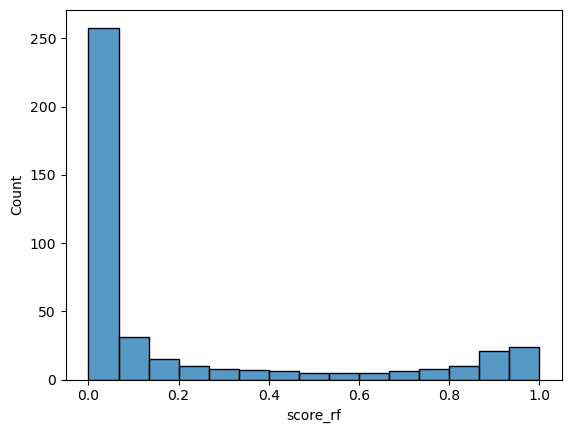

In [28]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [29]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))

FRAUD CAPTURA 30%:
0.9785202863961814


In [30]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,231731,402
2,232129,3
3,232128,5
4,232130,2
5,232132,1
...,...,...
96,232133,0
97,232132,0
98,232133,0


In [31]:
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.399400e-08  9.999999e-01
2             4.542972e-09  1.399388e-08
3             2.346960e-09  4.542884e-09
4             1.464275e-09  2.346944e-09
5             1.012221e-09  1.464271e-09
...                    ...           ...
96            5.033324e-13  6.047065e-13
97            4.020401e-13  5.033313e-13
98            2.982764e-13  4.020389e-13
99            1.863410e-13  2.982764e-13
100           1.787409e-15  1.863400e-13

[100 rows x 2 columns]

In [32]:
#PERC = pd.crosstab(Y_c.FRAUD_DECILE[testeo['mes']>8], Y_c.target[testeo['mes']>8])
#PERC.to_csv ('./percentiles.csv')

## Analizo distintos puntos de corte

In [33]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [34]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,2228,74
2,2405,34
3,2735,23
4,1422,61
5,1395,42
6,1338,64
7,1378,29
8,1469,36


In [35]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,4856,75
2,5175,37
3,5815,24
4,3040,61
5,3078,43
6,2938,65
7,3019,30
8,3078,37


In [36]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,7716,76
2,8139,39
3,9215,25
4,4682,61
5,4856,43
6,4637,65
7,4826,30
8,4836,37


In [37]:
#Veo cuantos falsos positivos tengo con el punto de corte
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,10612,76
2,11412,40
3,12765,25
4,6385,61
5,6638,44
6,6364,68
7,6642,30
8,6497,37


## Curva ROC y FP

In [38]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [39]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.880665278222125
ROC FRAUD TESTEO:
0.9720967665949626


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9531415902221514
Precision FRAUD TESTEO:
0.002124442267349612
Recall FRAUD TESTEO:
0.9522673031026253


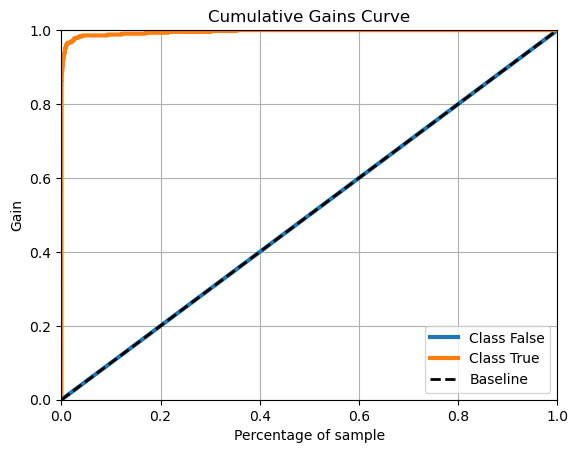

In [40]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


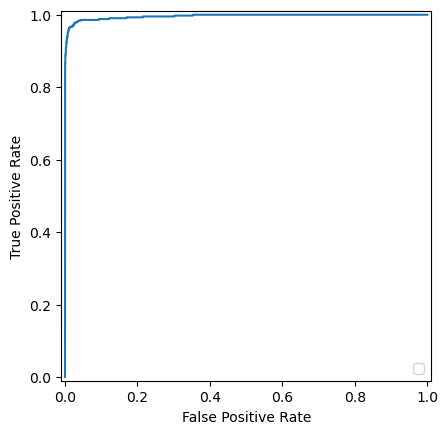

In [41]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

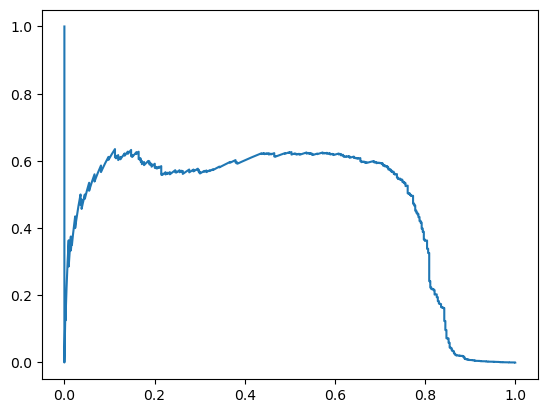

In [42]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [43]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

1.0

## Monthly analysis

In [44]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3732792,89
2,3887124,48
3,4381848,39
4,2116230,61
5,2289916,45
6,2193694,70
7,2314244,30
8,2296976,37


In [45]:
#Veo cuantos falsos positivos tengo con el punto de corte
tes_corte = testeo[Y_c['pred_corte']==True]
Y_c_corte = Y_c[Y_c['pred_corte']==True]

pd.crosstab(tes_corte['mes'], Y_c_corte['target'])

target,False,True
mes,,
1,30015,83
2,31952,43
3,36195,31
4,16976,61
5,18478,45
6,17832,69
7,18383,30
8,17584,37


In [46]:
Tabla_mes = pd.DataFrame(pd.concat([testeo['mes'],testeo['fraud_classification'], 
                                     Y_c['FRAUD_DECILE'], Y_c['target']],axis=1))

In [47]:
Tabla_mes[Tabla_mes['target']==True]
pd.crosstab(Tabla_mes.mes, Tabla_mes.FRAUD_DECILE)

FRAUD_DECILE,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
mes,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,37226,37304,37375,37287,37373,37172,37706,37483,37678,37450,37596,37643,37728,37761,37921,37607,38027,37520,37737,38045,37841,37752,38268,37896,37579,37897,37828,37929,38063,38039,37924,38186,38278,38337,37855,38076,37951,38167,38117,37720,38003,38159,38267,38312,38487,38302,37929,38235,37844,38198,38015,38353,38025,38173,37934,38126,37889,38034,37894,37584,37789,37821,37736,37676,37702,37590,36958,37278,37422,37267,37292,37335,37261,37148,36870,37117,36817,36393,36737,36561,36540,36622,36811,36509,36423,36118,35844,36027,35671,35518,35307,35160,35303,35239,35152,34898,34810,34868,35233,36953
2,39440,39811,39300,39512,39628,39772,39691,39749,39613,39836,39841,39929,39564,39880,39764,39926,39825,40097,39838,40238,39540,39880,40109,39681,39929,39898,40245,39851,39932,39877,39539,39754,39508,39660,39939,39326,39729,39329,39758,39736,39657,39419,39526,39593,39360,39512,39612,39102,39700,39275,39194,39405,39639,39372,39435,39387,39254,39075,39088,39141,39246,39230,38963,39093,39159,38856,38747,39165,38831,38821,38817,38782,38814,38733,38522,38516,38633,38531,38303,38283,38335,37961,37628,37799,37586,37692,37662,37049,36992,37025,36672,36465,36350,36359,35865,35769,35273,35041,34882,34502
3,44936,44975,45598,45485,44691,45295,45162,45236,44862,44859,44798,44802,44915,45015,45247,44685,45101,44648,44958,44683,45048,45066,44599,44823,44803,44767,44509,44423,44362,44584,44444,44224,44716,44493,44371,44547,44558,44150,44284,44373,44525,44118,44481,44195,43713,43972,44254,44037,43721,43997,43712,43689,43441,44154,43674,43993,43803,43179,43236,43718,43521,43379,43497,43618,43269,43782,43946,43429,43157,43404,43322,43283,43137,43231,43100,43046,43213,43055,42791,42957,42759,43227,43224,42847,42804,42701,42740,43030,42800,42732,42740,42707,42503,42335,42102,42064,41649,41309,40740,40030
4,20840,19707,19407,19283,18951,18947,19041,19008,19064,18867,18754,18844,18948,18796,18893,19265,18668,19017,18776,18478,18560,18705,18883,18624,18966,18812,18869,18891,18966,19050,18955,18804,19057,19086,19111,18975,19366,19187,19213,19174,19213,19184,19145,19445,19667,19236,19462,19687,19773,19654,19469,19763,19862,19778,20035,19914,20328,20437,20526,20484,20427,20687,20633,20808,20782,20854,21135,21190,21361,21353,21665,21625,22025,21957,22252,22101,22373,22931,22857,23025,23179,23525,23827,23748,24472,24368,24730,25156,25559,25861,25971,26496,27030,27366,28001,28295,29243,29800,30654,31099
5,22936,22592,22329,22258,22396,22015,21882,21695,21966,21954,21879,21747,21671,21449,21346,21766,21287,21404,21568,21456,21654,21585,21359,21483,21490,21320,21550,21643,21644,21538,21347,21785,21544,21526,21486,21620,21656,21731,21546,21772,21451,21773,21669,21608,21770,21775,21885,21956,22069,21910,22203,21855,22196,22099,22035,21947,22069,22230,22268,22461,22568,22525,22579,22564,22457,22737,22857,22875,23248,23211,22862,23078,23250,23627,23636,23617,23760,23574,24127,24183,24020,24357,24422,24826,25091,25036,25144,25030,25601,25851,25870,26056,26342,26622,26637,26591,27566,27822,27896,27742
6,22273,22844,22820,23075,22971,22843,22616,22961,22793,22720,22673,22707,22626,22583,22382,22395,22437,22512,22354,22153,22419,22313,22230,22211,22128,22197,21838,22225,22171,21796,22086,22065,21833,21996,21987,21919,22109,22128,21908,21941,21694,21736,21755,21673,21522,21658,21510,21669,21584,21399,21749,21708,21431,21354,21550,21516,21358,21546,21459,21505,21164,21321,21653,21072,21395,21621,21635,21440,21452,21429,21259,21427,21245,21254,21338,21679,21518,21534,21406,21398,21564,21422,21384,21505,21377,21603,21640,21749,21769,21675,21787,22071,22082,21771,22283,22731,225

In [48]:
pd.crosstab(Tabla_mes.mes[Tabla_mes['target']==True], Tabla_mes.FRAUD_DECILE[Tabla_mes['target']==True])

FRAUD_DECILE,1,2,3,4,5,10,13,17,22,31,36
mes,,,,,,,,,,,
1,85,1,1,0,0,0,0,0,1,0,1
2,44,1,0,1,0,0,1,1,0,0,0
3,31,1,4,1,0,1,0,0,0,1,0
4,61,0,0,0,0,0,0,0,0,0,0
5,45,0,0,0,0,0,0,0,0,0,0
6,69,0,0,0,1,0,0,0,0,0,0
7,30,0,0,0,0,0,0,0,0,0,0
8,37,0,0,0,0,0,0,0,0,0,0


In [49]:
Tabla_mes.loc[Tabla_mes['target']==True,['mes','fraud_classification','FRAUD_DECILE']]

,mes,fraud_classification,FRAUD_DECILE
18834,1,Real,1
29264,6,Real,1
124527,2,Real,1
357990,3,Real,1
392994,5,Real,1
...,...,...,...
22178813,3,Real,1
22489783,3,Real,31
23006071,3,Real,1
23028774,3,Real,1


# Monthly indicators

In [62]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_02'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_02'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_02']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.026515,0.984375,2376,64,64,63
0,2,2023,0.012472,1.0,2726,34,34,34
5,3,2023,0.006703,0.954545,3133,22,22,21
1,4,2023,0.019671,1.0,3101,61,61,61
2,5,2023,0.013778,0.955556,3121,45,45,43
3,6,2023,0.021645,0.928571,3003,70,70,65
4,7,2023,0.009839,1.0,3049,30,30,30
7,8,2023,0.011878,1.0,3115,37,37,37
10,1,2024,0.004697,0.48,2555,25,25,12
8,2,2024,0.001207,0.214286,2486,14,14,3


In [51]:
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
6,1,2023,0.055308,0.96875,1121,64,64,62
0,2,2023,0.026835,1.0,1267,34,34,34
5,3,2023,0.013852,0.954545,1516,22,22,21
1,4,2023,0.041133,1.0,1483,61,61,61
2,5,2023,0.029228,0.933333,1437,45,45,42
3,6,2023,0.045649,0.914286,1402,70,70,64
4,7,2023,0.020611,0.966667,1407,30,30,29
7,8,2023,0.02392,0.972973,1505,37,37,36
10,1,2024,0.010161,0.48,1181,25,25,12
8,2,2024,0.0,0.0,1172,14,14,0


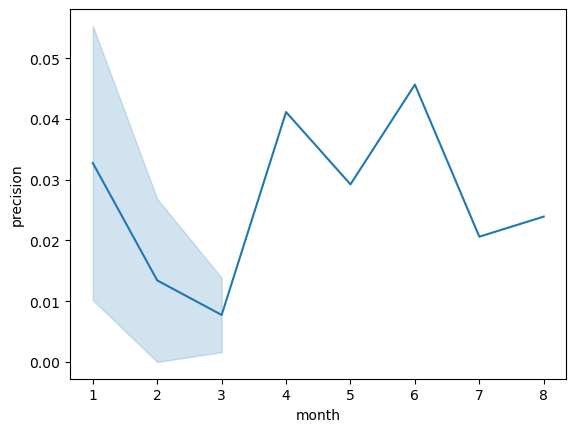

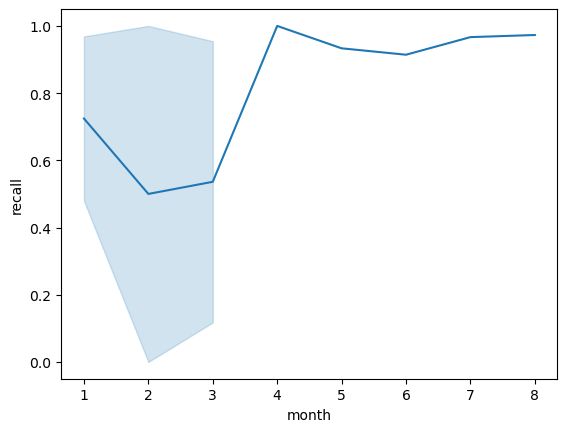

In [52]:
# Recall and precision by month
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [53]:
tes_corte_01['date_receiver'].dt.floor('d')

2881       2023-03-06
3808       2023-04-03
6147       2023-01-11
10313      2023-08-30
12119      2023-02-25
              ...    
23202049   2024-03-11
23203464   2024-03-15
23203932   2024-03-16
23204027   2024-03-15
23212763   2024-03-22
Name: date_receiver, Length: 14733, dtype: datetime64[ns]

In [54]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
#ALERTAS_01.to_csv ('./alertas.csv')

In [55]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,15,0
2023-01-02,22,0
2023-01-03,28,0
2023-01-04,50,11
2023-01-05,28,20
...,...,...
2024-03-26,15,0
2024-03-27,23,0
2024-03-28,14,0


In [56]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [57]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2024-03-27,52849,0
2024-03-28,48518,0
2024-03-29,65119,0


In [58]:
week_testigo = testeo['date_receiver'].between('2024-02-21','2024-02-28')
X_week_testigo = testeo[week_testigo]
Y_c_week_testigo = Y_c[week_testigo]

week_testigo.sum(), X_week_testigo.shape, Y_c_week_testigo.shape

(514265, (514265, 78), (514265, 18))

In [59]:
X_week_testigo_corte = X_week_testigo[Y_c_week_testigo['pred_corte_01']==True]
Y_c_week_testigo_corte = Y_c_week_testigo[Y_c_week_testigo['pred_corte_01']==True]

pd.crosstab(X_week_testigo_corte['date_receiver'].dt.day, Y_c_week_testigo_corte['target'])

target,False
date_receiver,
21,33
22,44
23,52
24,51
25,51
26,38
27,41


In [60]:
X_week_testigo_corte[['id_branch','id_receiver']].to_csv ('./alertas2024.csv')

In [61]:
X.date_receiver[X['01_var_range_hist']>1000].max()

Timestamp('2023-08-31 18:55:30.910000')